In [2]:
import sys
sys.path.append('E:\work\code\my_project')
import pandas as pd
import numpy as np
import os
import datetime
import scorecardpy as sc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score,train_test_split,StratifiedKFold
from sklearn.metrics import SCORERS
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from unity import feature_selector as fs
from unity.fea_eda_func import FeaEdaFunc
from unity.eda_func import EdaFunc

## 3.特征工程

### 3.1 数据清洗-剔除单一特征与缺失率超过0.7的特征

In [3]:
main_df = pd.read_csv('main_df.csv')
# main_df = pd.read_csv('main_df_drop_zj.csv')

D:\tools\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (323,386,387,397,420,425,507,539,556,564,568,576,599,630,637,646) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
main_df = main_df.replace([-9988,-9989],np.nan)

In [5]:
fsc = fs.FeatureSelector(main_df,labels='tag')

In [6]:
fsc.identify_missing(0.7)
fsc.identify_single_unique()
# fsc.identify_collinear(0.9)

300 features with greater than 0.70 missing values.

121 features with a single unique value.



In [7]:
remove_feas = fsc.check_removal()

Total of 394 features identified for removal


In [8]:
main_df = main_df.drop(remove_feas,axis=1)

In [9]:
train_set = main_df[main_df['obj_date'] != '2020-06-30']
oot_set = main_df[main_df['obj_date'] == '2020-06-30']

In [10]:
train_set['tag'].value_counts()

0    1801
1     200
Name: tag, dtype: int64

In [11]:
oot_set['tag'].value_counts()

0    1312
1     148
Name: tag, dtype: int64

In [12]:
train_set['tag'].value_counts()/len(train_set)

0    0.90005
1    0.09995
Name: tag, dtype: float64

In [13]:
# 包括专家特征
train_set = train_set.drop(['cust_no', 'obs_dt', 'obj_date', 'p', 'req_id', 'businessid'],axis=1)
oot_set = oot_set.drop(['cust_no', 'obs_dt', 'obj_date', 'p', 'req_id', 'businessid'],axis=1)

### 3.2 类别变量处理

In [15]:
# train_set['dubil_num_3'].astype(float)

In [16]:
fea_types = train_set.dtypes
fea_types[fea_types == 'object']

WN_TAX008    object
area         object
dtype: object

In [589]:
# 包括专家特征
train_set['area'] = train_set['area'].replace({'上海':1,'厦门':2,'福建':3})
oot_set['area'] = oot_set['area'].replace({'上海':1,'厦门':2,'福建':3})

In [590]:
# 包括专家特征
unique_feas = ['count_normalpayoff_loan_3', 'count_normalpayoff_loan_6', 'count_normalpayoff_loan_9', 'count_normalpayoff_loan_12', 
               'count_ovduepayoff_loan_3', 'count_ovduepayoff_loan_6', 'count_ovduepayoff_loan_9', 'count_ovduepayoff_loan_12',
               'zxgcsste','WN_ICR022', 'WN_ICR040', 'WN_LEG039', 'WN_LEG033', 'warn_state']
train_set = train_set.drop(unique_feas,axis=1)
oot_set = oot_set.drop(unique_feas,axis=1)

In [591]:
train_set.shape

(2001, 248)

In [592]:
oot_set.shape

(1460, 248)

### 3.3 划分样本

In [593]:
# tra_x,tst_x,tra_y,tst_y = train_test_split(train_set,train_set['tag'],shuffle=True,test_size=0.3,random_state=2)
tra_x = train_set.copy()
tra_y = train_set['tag']
oot_x = oot_set.copy()
oot_y = oot_set['tag']

In [594]:
tra_y.value_counts()

0    1801
1     200
Name: tag, dtype: int64

In [595]:
oot_y.value_counts()

0    1312
1     148
Name: tag, dtype: int64

* <font size=4 color=red face=仿宋>直接先用树模型筛选特征</font>

In [596]:
# 包括专家特征
cat_feas = ['WN_BNK007','WN_TAX008','tag']
tra_x = tra_x.drop(cat_feas,axis=1)
oot_x = oot_x.drop(cat_feas,axis=1)
# 不包括专家特征
# cat_feas = ['tag']
# tra_x = tra_x.drop(cat_feas,axis=1)
# tst_x = tst_x.drop(cat_feas,axis=1)
# oot_x = oot_x.drop(cat_feas,axis=1)

In [597]:
# tra_x = tra_x.apply(lambda x:x.fillna(x.median()))
# tst_x = tst_x.apply(lambda x:x.fillna(x.median()))
# oot_x = oot_x.apply(lambda x:x.fillna(x.median()))

tra_x = tra_x.apply(lambda x:x.replace({np.inf:np.nan}))
# tst_x = tst_x.apply(lambda x:x.replace({np.inf:np.nan}))
oot_x = oot_x.apply(lambda x:x.replace({np.inf:np.nan}))

In [598]:
np.where(tra_x == np.inf)

(array([], dtype=int64), array([], dtype=int64))

#### 交叉验证筛选特征

In [599]:
# skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=2)

In [600]:
# sele = set()
# n = 1
# for tra_index,tst_index in skf.split(tra_x,tra_y):
#     print(f'第{n}折')
#     ktrax = tra_x.iloc[tra_index,:]
#     ktray = tra_y.iloc[tra_index]
#     ktstx = tra_x.iloc[tst_index,:]
#     ktxty = tra_y.iloc[tst_index]
#     clf = RandomForestClassifier(random_state=2)
#     clf.fit(ktrax,ktray)
#     imp = pd.DataFrame(clf.feature_importances_,index=tra_x.columns,columns=['importance']).sort_values('importance',ascending=False)
#     sele = sele | set(imp['importance'].head(50).index)
#     n+=1

In [601]:
# tra_x = tra_x.drop('tag',axis=1)
# tst_x = tst_x.drop('tag',axis=1)
clf = LGBMClassifier(random_state=2,class_weight='balanced')
clf.fit(tra_x,tra_y)
tra_pred_y = clf.predict_proba(tra_x)[:,1]
imp = pd.DataFrame(clf.feature_importances_,index=tra_x.columns,columns=['importance']).sort_values('importance',ascending=False)
sele = set(imp['importance'].head(50).index)

In [602]:
tra_x = tra_x[sele]
# tst_x = tst_x[sele]
oot_x = oot_x[sele]

In [603]:
# tra_x = tra_x.drop(hcorr_lis,axis=1)
# tst_x = tst_x.drop(hcorr_lis,axis=1)
# oot_x = oot_x.drop(hcorr_lis,axis=1)

In [604]:
# clf.fit(tra_x,tra_y)
# tra_pred_y = clf.predict_proba(tra_x)[:,1]
# tst_pred_y = clf.predict_proba(tst_x)[:,1]
# oot_pred_y = clf.predict_proba(oot_x)[:,1]

In [605]:
# sc.perf_eva(tra_y,tra_pred_y)   

In [606]:
# sc.perf_eva(tst_y,tst_pred_y)   

In [607]:
# sc.perf_eva(oot_y,oot_pred_y)    

### 3.3 决策树分箱

In [608]:
tra_x = pd.concat([tra_x,tra_y],axis=1)
# tst_x = pd.concat([tst_x,tst_y],axis=1)
oot_x = pd.concat([oot_x,oot_y],axis=1)

In [609]:
bins_dic  =sc.woebin(tra_x,y='tag',method='chimerge')

[INFO] creating woe binning ...
Binning on 2001 rows and 51 columns in 00:00:12


### 3.4 调整分箱

In [610]:
fea_info = FeaEdaFunc.filter_fea(bins_dic)
fea_info = fea_info.sort_values('iv',ascending=False)
fea_info[fea_info['mono_status'] == False]

,mono_status,iv
variable,,
WN_ICR120,False,0.415574
WN_TAX019,False,0.265845
zxysavgloanbalanceamt,False,0.258340
WN_TAX024,False,0.234236
WN_TAX025,False,0.185863
WN_TAX027,False,0.183887
zxcrdpctrmbcurccpr,False,0.167423
WN_TAX026,False,0.152524
zxcasumstallcurccpr,False,0.147604


In [611]:
# sc.woebin_plot(bins_dic,x=fea_info[fea_info['iv'] > 0.05].index.to_list())

In [612]:
adj_bin = sc.woebin(tra_x,x=['zxage','zxysavgloanbalanceamt','zxcrdpctrmbcurccpr','zxnmlccusedamt','WN_TAX012','WN_ICR120',
                             'zxcasumstallcurccpr','zxutpggt6uplpr'],
                    y='tag',
                    breaks_list={'zxage':[35,46],'zxysavgloanbalanceamt':[80000,220000,680000],'zxcrdpctrmbcurccpr':[15,25,80],
                                 'zxnmlccusedamt':[80000,150000,450000,750000],'WN_TAX012':[210000,260000],'WN_ICR120':[3,6,8],
                                 'zxcasumstallcurccpr':[200000,400000,900000],'zxutpggt6uplpr':[1,2]}
                   )

[INFO] creating woe binning ...


{'zxysavgloanbalanceamt': <Figure size 432x288 with 2 Axes>,
 'zxage': <Figure size 432x288 with 2 Axes>,
 'zxcrdpctrmbcurccpr': <Figure size 432x288 with 2 Axes>,
 'zxnmlccusedamt': <Figure size 432x288 with 2 Axes>,
 'WN_TAX012': <Figure size 432x288 with 2 Axes>,
 'WN_ICR120': <Figure size 432x288 with 2 Axes>,
 'zxcasumstallcurccpr': <Figure size 432x288 with 2 Axes>,
 'zxutpggt6uplpr': <Figure size 432x288 with 2 Axes>}

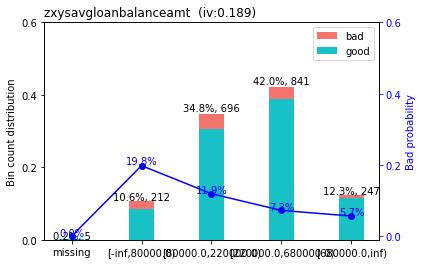

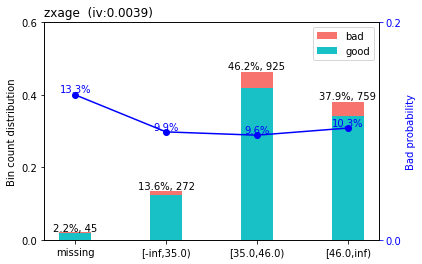

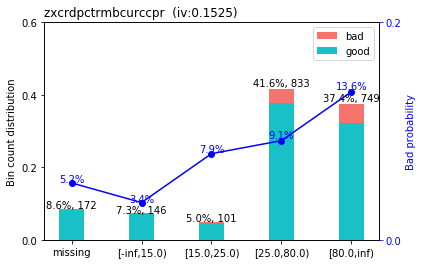

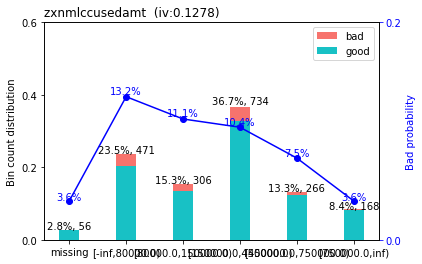

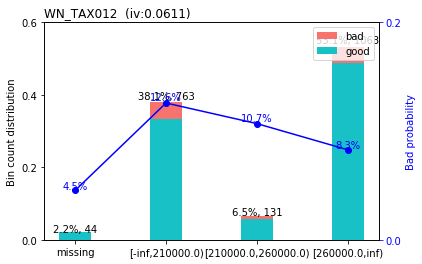

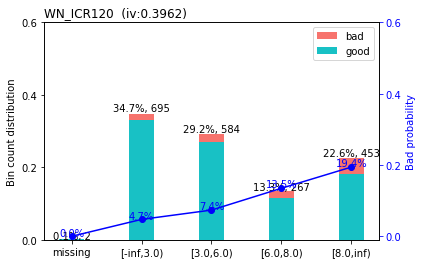

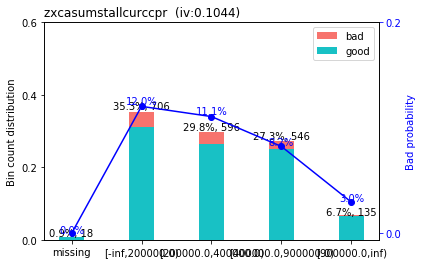

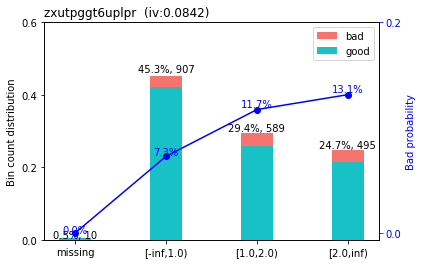

In [613]:
sc.woebin_plot(adj_bin,x=['zxysavgloanbalanceamt','zxage','zxcrdpctrmbcurccpr','zxnmlccusedamt','WN_TAX012','WN_ICR120',
                          'zxcasumstallcurccpr','zxutpggt6uplpr'])

In [614]:
# sc.woebin_plot(bins_dic,x=['zxutpggt6uplpr'])

In [615]:
# bins_dic['zxutpggt6uplpr']

In [616]:
bins_dic.update(adj_bin)

### 3.5 剔除iv<0.05的特征

In [497]:
fea_info = FeaEdaFunc.filter_fea(bins_dic)
fea_info = fea_info.sort_values('iv',ascending=False)
fea_info[fea_info['mono_status'] == False]

,mono_status,iv
variable,,
WN_TAX019,False,0.265845
WN_TAX024,False,0.234236
zxysavgloanbalanceamt,False,0.188997
WN_TAX025,False,0.185863
WN_TAX027,False,0.183887
WN_TAX026,False,0.152524
zxcrdpctrmbcurccpr,False,0.152493
zxcasumstrmbcurccpr,False,0.136897
WN_TAX011,False,0.131641


In [498]:
ivdrop_feas = fea_info[fea_info['iv'] < 0.1].index.to_list()

In [499]:
bins_drop_dic = [bins_dic.pop(k) for k in ivdrop_feas]

In [500]:
tra_x = tra_x.drop(ivdrop_feas,axis=1)
# tst_x = tst_x.drop(ivdrop_feas,axis=1)
oot_x = oot_x.drop(ivdrop_feas,axis=1)

### 3.5 woe

In [501]:
tra_x_woe = sc.woebin_ply(tra_x,bins_dic)
# tst_x_woe = sc.woebin_ply(tst_x,bins_dic)
oot_x_woe = sc.woebin_ply(oot_x,bins_dic)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


### 3.6 剔除psi大于0.1的特征

In [502]:
# tst_bin_group = FeaEdaFunc.bin_group(tst_x_woe,cols=tst_x_woe.iloc[:,1:].columns,target='tag')
# oot_bin_group = FeaEdaFunc.bin_group(oot_x_woe,cols=tst_x_woe.iloc[:,1:].columns,target='tag')

In [503]:
def calc_psi(bindic,exp,act):
    psi_dic = {}
    con_dic = {}
    for k,b in bindic.items():
        g1 = exp[[k]].fillna('missing')
        g2 = act[[k]].fillna('missing')
        cut_bin = b.loc[b['breaks']!= 'missing','breaks'].astype(float)
        cut_bin.loc[len(cut_bin)+1] = '-inf'
        cut_bin = cut_bin.astype(float).sort_values()
        g1['c'] = pd.cut(g1.loc[g1[k] != 'missing',k],bins=cut_bin,right=False)
        g2['c'] = pd.cut(g2.loc[g2[k] != 'missing',k],bins=cut_bin,right=False)
        g1['c'] = g1['c'].astype(str)
        g1.loc[g1[k] == 'missing','c'] = 'missing'
        count_a = g1.groupby('c').size()/len(g1)
        g2['c'] = g2['c'].astype(str)
        g2.loc[g2[k] == 'missing','c'] = 'missing'
        count_e = g2.groupby('c').size()/len(g2)
        con = pd.concat([count_a,count_e],axis=1,keys=['a','e'])
        con['a-e'] = con['a'] - con['e']
        con['ln(a/e)'] = np.log(con['a']/con['e'])
        con_dic[k] = con
        x = (con['a'] - con['e'])*np.log(con['a']/con['e'])
        x = x[~x.isnull()]
        psi = sum(x)
        psi_dic[k] = psi
    return psi_dic,con_dic

In [504]:
psi_info,con_info = calc_psi(bins_dic,tra_x,oot_x)

/home/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [505]:
psi_df = pd.DataFrame(psi_info,index=['psi']).T.sort_values('psi',ascending=False)

In [506]:
psi_drop = set(psi_df[psi_df['psi']>0.05].index)

In [507]:
psi_drop = [i+'_woe' for i in psi_drop]

In [508]:
psi_drop

['WN_TAX026_woe',
 'amtlosumstrmbcurhllo_woe',
 'WN_TAX017_woe',
 'WN_TAX029_woe',
 'WN_MIX027_woe',
 'WN_ICR043_woe',
 'WN_TAX019_woe']

### 3.7 共线性剔除 

In [509]:
# tra_x_woe.corr().style.background_gradient()

In [510]:
tra_x_woe = tra_x_woe.drop(psi_drop,axis=1)
oot_x_woe = oot_x_woe.drop(psi_drop,axis=1)

In [511]:
tra_x_woe = tra_x_woe.drop('tag',axis=1).reset_index(drop=True)
oot_y = oot_x_woe['tag'].reset_index(drop=True)
oot_x_woe = oot_x_woe.drop('tag',axis=1).reset_index(drop=True)

### 3.8 初步测试

In [512]:
# def val_clf(x,y,oot_x,oot_y,score,clf=LGBMClassifier(),pert_func=sc.perf_eva):
#     tra_x,tst_x,tra_y,tst_y = train_test_split(x,y,test_size=0.3,shuffle=True)
#     clf.fit(tra_x,tra_y)
#     pred_y = clf.predict_proba(tst_x)[:,1]
#     oot_pred_y = clf.predict_proba(oot_x)[:,1]
#     if pert_func:
#         pert_func(tst_y,pred_y)
#         pert_func(oot_y,oot_pred_y)
#     else:
#         print(score(tst_y,pred_y))

In [513]:
oot_x_woe = oot_x_woe.apply(lambda x:x.fillna(x.median()))

In [514]:
tra_x_woe.shape

(2001, 13)

In [515]:
clf = LogisticRegression(class_weight='balanced')
# clf = RandomForestClassifier(class_weight='balanced')
# clf = DecisionTreeClassifier(class_weight='balanced')
# clf = LGBMClassifier(class_weight='balanced')
clf.fit(tra_x_woe,tra_y)
tra_pred_y = clf.predict_proba(tra_x_woe)[:,1]
oot_pred_y = clf.predict_proba(oot_x_woe)[:,1]

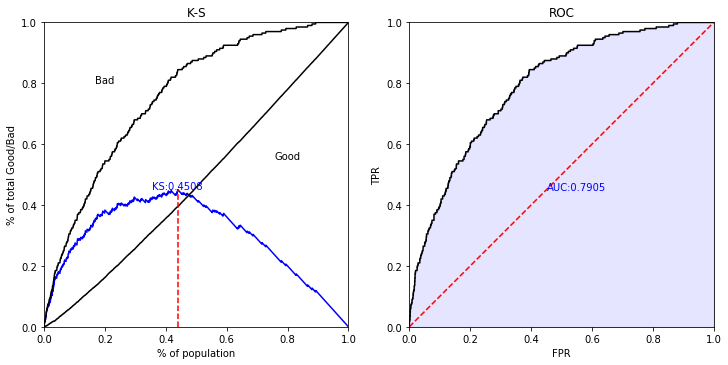

{'KS': 0.4508,
 'AUC': 0.7905,
 'Gini': 0.581,
 'pic': <Figure size 864x432 with 2 Axes>}

In [516]:
sc.perf_eva(tra_y,tra_pred_y)  

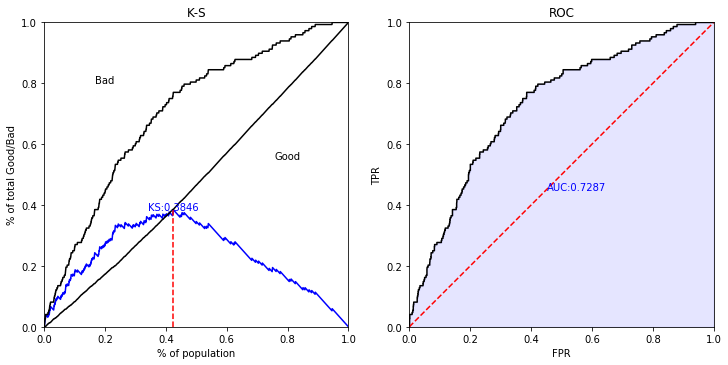

{'KS': 0.3846,
 'AUC': 0.7287,
 'Gini': 0.4574,
 'pic': <Figure size 864x432 with 2 Axes>}

In [517]:
sc.perf_eva(oot_y,oot_pred_y)  

In [518]:
# error_drop_feas = ['WN_TAX015_woe','zxutlpctrmbcurccpr_woe','WN_TAX027_woe','zxhomeaddrcnt_woe','WN_ICR002_woe','WN_MIX025_woe',
# 'zxracplpr_woe']
# error_drop_feas = ['zxracplpr_woe']
# tra_x_woe.drop(error_drop_feas,axis=1,inplace=True)
# tst_x_woe.drop(error_drop_feas,axis=1,inplace=True)
# oot_x_woe.drop(error_drop_feas,axis=1,inplace=True)

In [519]:
oot_x_woe.shape

(1460, 13)

### 3.9 逐步回归

In [520]:
step_drop_feas,step_res = FeaEdaFunc.step_logit(tra_x_woe,tra_y)

Optimization terminated successfully.
         Current function value: 0.324973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.307685
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.299256
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.291753
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287223
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.281886
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.278405
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.275408
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.272936
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.272936
  

In [521]:
tra_x_woe.drop(step_drop_feas,axis=1,inplace=True)
oot_x_woe.drop(step_drop_feas,axis=1,inplace=True)

## 4.建立分类模型

In [522]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(tra_x_woe,tra_y)
tra_pred_y = clf.predict_proba(tra_x_woe)[:,1]
oot_pred_y = clf.predict_proba(oot_x_woe)[:,1]
tauc = roc_auc_score(tra_y,tra_pred_y)
oauc = roc_auc_score(oot_y,oot_pred_y)

In [572]:
fpr,tpr,threshold = roc_curve(tra_y,tra_pred_y)

In [573]:
threshold

array([1.95458096, 0.95458096, 0.95258357, 0.93986125, 0.93735454,
       0.93596281, 0.93330513, 0.91926757, 0.91719231, 0.91417404,
       0.91379947, 0.91168589, 0.90977879, 0.90932014, 0.90614339,
       0.90577667, 0.90489137, 0.89290831, 0.88803572, 0.88172985,
       0.87962555, 0.87641564, 0.87523511, 0.87508776, 0.87376849,
       0.87371215, 0.87120315, 0.87030999, 0.87012284, 0.86897774,
       0.86596225, 0.86287578, 0.86236569, 0.85983933, 0.85522619,
       0.85403726, 0.85310864, 0.8525094 , 0.8507879 , 0.84548996,
       0.84416449, 0.84332967, 0.84329051, 0.8402007 , 0.83909923,
       0.83404749, 0.83037009, 0.82992671, 0.82857166, 0.82662758,
       0.82213365, 0.8209756 , 0.81990606, 0.81893724, 0.81842185,
       0.81830539, 0.8144447 , 0.81222836, 0.81212911, 0.81075299,
       0.81055544, 0.80888499, 0.80827226, 0.80814735, 0.80676972,
       0.80556189, 0.80297905, 0.80247625, 0.80104125, 0.7994651 ,
       0.79903746, 0.79792644, 0.79792614, 0.79774901, 0.79731

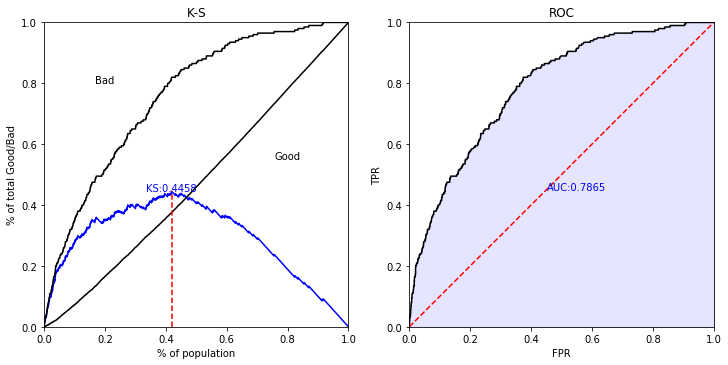

{'KS': 0.4458,
 'AUC': 0.7865,
 'Gini': 0.573,
 'pic': <Figure size 864x432 with 2 Axes>}

In [523]:
sc.perf_eva(tra_y,tra_pred_y)  

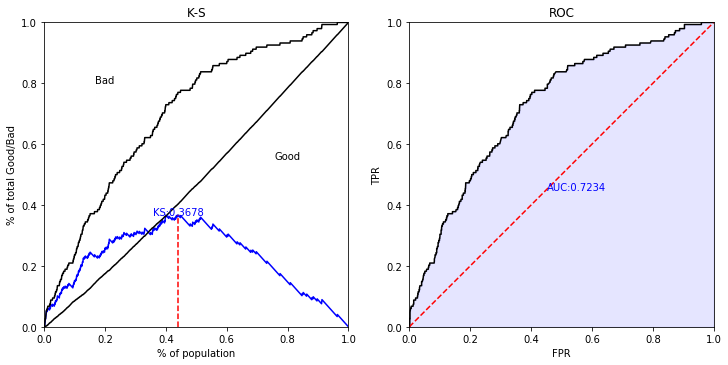

{'KS': 0.3678,
 'AUC': 0.7234,
 'Gini': 0.4467,
 'pic': <Figure size 864x432 with 2 Axes>}

In [524]:
sc.perf_eva(oot_y,oot_pred_y) 

## 5.计算得分

In [525]:
fin_feas = [i.split('_woe')[0] for i in tra_x_woe]
tra_x = tra_x[fin_feas]
oot_x = oot_x[fin_feas]

In [526]:
card = sc.scorecard(bins_dic,clf,tra_x.columns)

In [527]:
tra_score = sc.scorecard_ply(tra_x, card, only_total_score=False)
oot_score = sc.scorecard_ply(oot_x, card, only_total_score=False)

In [528]:
scpsi = sc.perf_psi(score={'train':tra_score,'test':oot_score},label={'train':tra_y,'test':oot_y},show_plot=False)

/home/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


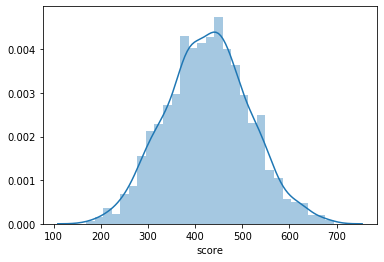

In [533]:
import seaborn as sns
sns.distplot(tra_score['score'])

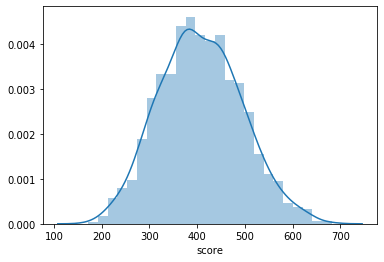

In [534]:
sns.distplot(oot_score['score'])

## 6.整理特征输出

In [566]:
dhname = pd.read_excel('data/贷后预警特征对照.xlsx',sheet_name='指标计算逻辑',header=4)
zxname = pd.read_csv('data/zxvarname.csv')

In [567]:
dhname = dhname[['指标名称','指标代码']]
dhname['类型'] = '贷后预警'
dhname.head()

,指标名称,指标代码,类型
0,个人较上期新增未销户逾期贷记卡、准贷记卡账户数（行内）,WN_BNK001,贷后预警
1,个人较上期新增未结清逾期贷款笔数（行内）,WN_BNK007,贷后预警
2,企业较上期新增未结清欠息余额（行内）,WN_BNK033,贷后预警
3,个人或企业本期命中黑名单,WN_BNK041,贷后预警
4,企业当前未结清业务逾期笔数（行内）,WN_BNK043,贷后预警


In [568]:
zxname = zxname[zxname['var'].isin(main_df.loc[:,main_df.columns.str.contains('zx')].columns)][['yd_var_name','var']]
zxname = zxname.drop_duplicates()

In [569]:
zxname.columns=['指标名称','指标代码']
zxname['类型'] = '征信'

In [571]:
dhname.append(zxname).to_csv('特征清单.csv',index=False,encoding='gbk')